### 受限玻尔兹曼机（RBM）原理与代码实现总结
---
#### **一、RBM原理概述**
受限玻尔兹曼机（Restricted Boltzmann Machine）是一种基于能量的概率图模型，由可见层（Visible Layer）和隐层（Hidden Layer）组成，层内无连接，层间全连接。其核心是通过无监督学习学习数据的潜在特征分布。
##### **1. 模型结构**
- **可见层（v）**：输入数据的显式表示（如像素值）。
- **隐层（h）**：提取的潜在特征。
- **权重矩阵（W）**：连接可见层与隐层的权重。
- **偏置**：可见层偏置（b）和隐层偏置（c）。
##### **2. 能量函数与概率分布**
RBM的能量函数定义为：
$$
E(\mathbf{v}, \mathbf{h}) = -\mathbf{v}^T W \mathbf{h} - \mathbf{b}^T \mathbf{v} - \mathbf{c}^T \mathbf{h}
$$
联合概率分布通过玻尔兹曼分布给出：
$$
P(\mathbf{v}, \mathbf{h}) = \frac{ e^{-E(\mathbf{v}, \mathbf{h})} }{Z}
$$
其中 $ Z $ 为配分函数（归一化因子）。可见层的边缘分布为：
$$
P(\mathbf{v}) = \sum_{\mathbf{h}} P(\mathbf{v}, \mathbf{h})
$$
##### **3. 条件独立性**
由于层内无连接，给定可见层时隐层条件独立，反之亦然：
$$
P(h_j=1|\mathbf{v}) = \sigma\left(\sum_i W_{ij} v_i + c_j\right)
$$
$$
P(v_i=1|\mathbf{h}) = \sigma\left(\sum_j W_{ij} h_j + b_i\right)
$$
其中 $\sigma(x) = \frac{1}{1+e^{-x}}$ 为Sigmoid激活函数。
##### **4. 训练目标**
通过最大化似然函数学习参数（W, b, c）。目标函数为负对数似然：
$$
\mathcal{L} = -\sum_{\mathbf{v}} \log P(\mathbf{v})
$$
采用对比散度（CD）算法近似梯度，更新规则为：
$$
\Delta W_{ij} = \epsilon \left(\langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{recon}}\right)
$$
其中 $\epsilon$ 为学习率，$\langle \cdot \rangle_{\text{data}}$ 和 $\langle \cdot \rangle_{\text{recon}}$ 分别为数据分布和重构分布的期望。

---
#### **二、代码内容概括**
代码实现了RBM的训练与可视化，主要包含以下部分：
##### **1. 核心类 `RBMRunner`**
- **功能**：封装RBM训练、数据增强、可视化及评估流程。
- **关键参数**：
  - `n_components`：隐层单元数（默认256）。
  - `learning_rate`：学习率（默认0.1）。
  - `batch_size`：批大小（默认100）。
  - `n_iter`：迭代次数（默认30）。
- **设备支持**：自动选择GPU（`cuda`）或CPU。
##### **2. 训练流程 (`fit` 方法)**
- **初始化RBM**：使用 `RestrictedBoltzmannMachine` 定义可见层与隐层维度。
- **优化器**：采用随机梯度下降（SGD）优化参数。
- **训练步骤**：
  1. **正相（Positive Phase）**：计算隐层激活概率 $ P(\mathbf{h}|\mathbf{v}) $。
  2. **负相（Negative Phase）**：通过模拟退火采样器（`SimulatedAnnealingOptimizer`）生成重构样本。
  3. **目标函数**：最小化能量函数加权重衰减（L2正则化）。
  4. **反向传播**：更新权重和偏置。
##### **3. 其他内容**

- **数据加载 (`load_data` 方法)**

    - 数据集：使用 `sklearn.datasets.load_digits`（8x8手写数字图像）。
    - 增强：对原始图像进行上下左右平移，扩展数据集。

- **可视化输出**

    - 生成样本：展示RBM学习到的数据分布。
    - 权重与梯度：可视化权重矩阵及其梯度变化。


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

seed = 17171
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)       # 为当前GPU设置
    torch.cuda.manual_seed_all(seed)   # 为所有GPU设置
# Python
random.seed(seed)
# NumPy
np.random.seed(seed)

Iteration 1, Objective: 0.043350
jmean 0.014845985919237137 jmax 0.05673268064856529
hmean 0.00824352353811264 hmax 0.053993698209524155
Iteration 2, Objective: -6.240361
Iteration 3, Objective: -3.523015
Iteration 4, Objective: -2.660822
Iteration 5, Objective: -1.428278
Iteration 6, Objective: -1.036314
Iteration 7, Objective: -1.161182
Iteration 8, Objective: -1.511463
Iteration 9, Objective: -1.566934
Iteration 10, Objective: -0.740557
Iteration 11, Objective: -1.207124
Iteration 12, Objective: -1.490963
Iteration 13, Objective: 0.137224
Iteration 14, Objective: 0.279784
Iteration 15, Objective: 0.727845
Iteration 16, Objective: 0.086017
Iteration 17, Objective: -0.818525
Iteration 18, Objective: 0.006313
Iteration 19, Objective: -0.298363
Iteration 20, Objective: -0.732824
Iteration 21, Objective: 1.192804
jmean 0.024533957242965698 jmax 0.08602593094110489
hmean 0.013012292794883251 hmax 0.11755593866109848
Iteration 22, Objective: 0.366588
Iteration 23, Objective: 0.643655
Itera

e:\ProgramData\miniconda3\envs\py310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RBM Pipline training completed in 7.68 seconds
Logistic regression training completed in 1.52 seconds

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       188
           1       0.58      0.49      0.53       183
           2       0.82      0.78      0.80       172
           3       0.78      0.79      0.78       205
           4       0.83      0.86      0.85       168
           5       0.76      0.75      0.75       183
           6       0.90      0.91      0.90       183
           7       0.85      0.89      0.87       189
           8       0.65      0.63      0.64       160
           9       0.67      0.69      0.68       166

    accuracy                           0.77      1797
   macro avg       0.77      0.77      0.77      1797
weighted avg       0.77      0.77      0.77      1797


Test Accuracy: 0.7741

Logistic regression using raw pixel features:
              precision    r

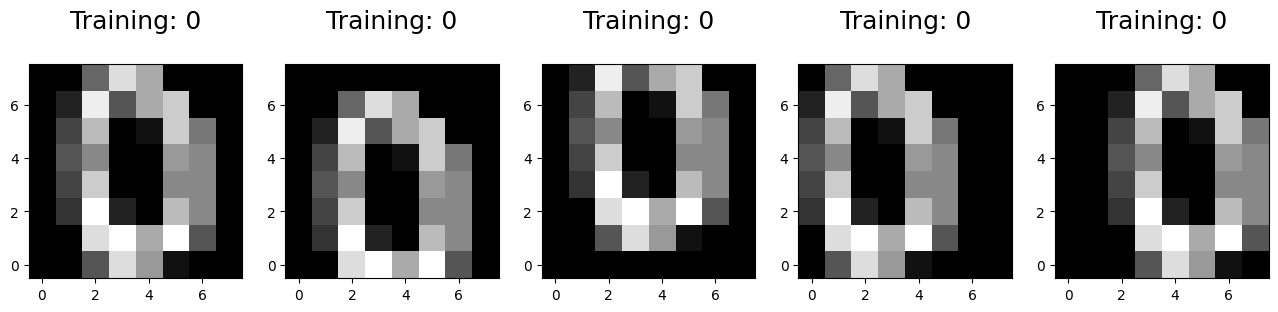

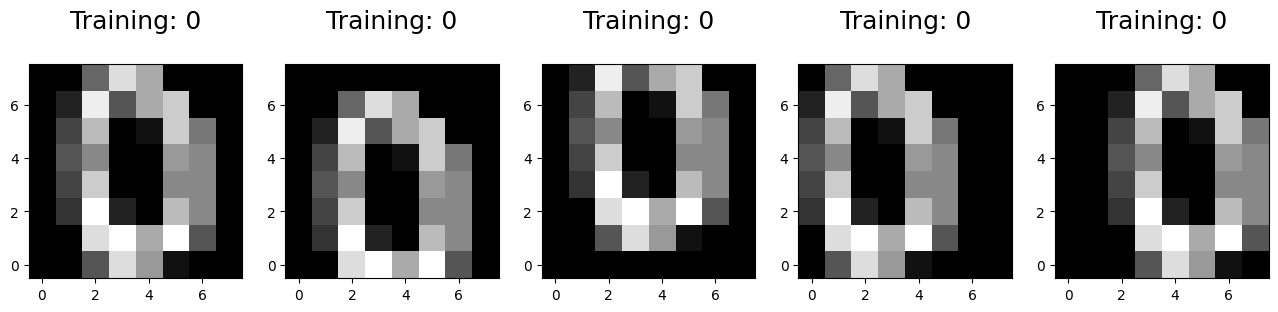

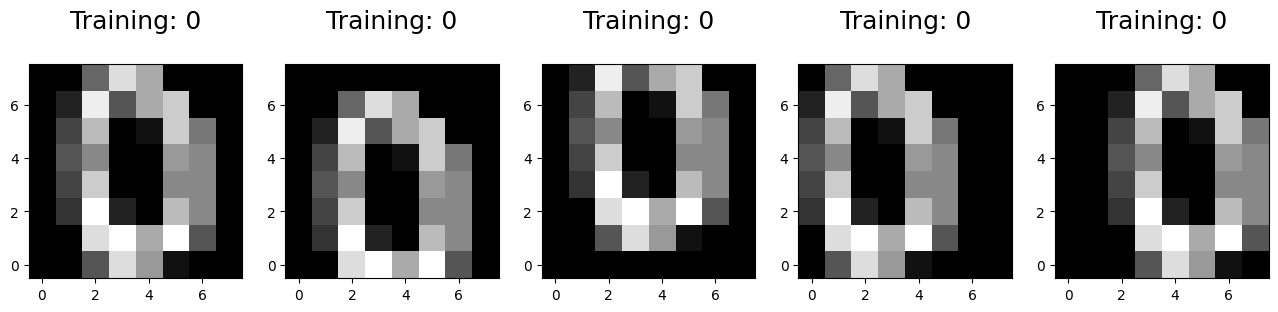

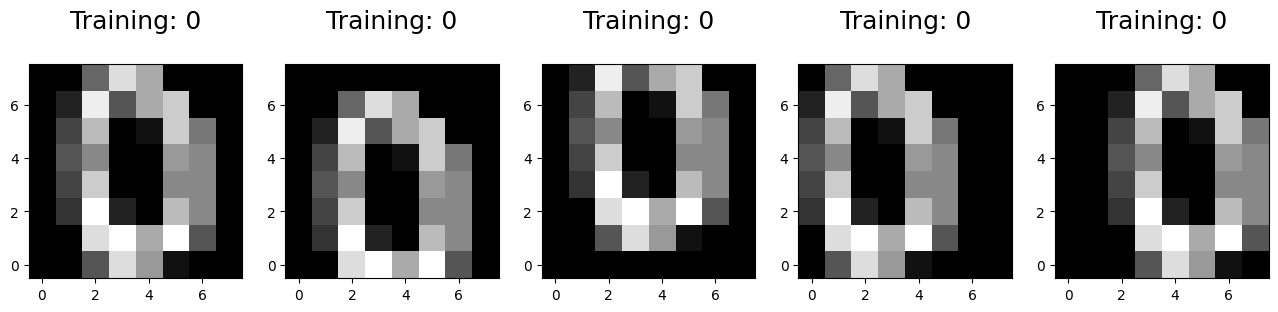

In [2]:
from rbm_digits import  RBMRunner
import kaiwu as kw
# 添加license相关信息
# kw.license.init(user_id="", sdk_code="")
for _ in range(4):
    logistic = LogisticRegression(random_state=42)

    # 初始化RBM
    rbm = RBMRunner(
        n_components=128, 
        learning_rate=0.1, 
        batch_size=32, 
        n_iter=2, 
        verbose=True, 
        plot_img=False,
        random_state=seed
    )

    #加载数据
    X_train, X_test, y_train, y_test = rbm.load_data(plot_img=True)

    classifier = Pipeline(steps=[('rbm', rbm),
                                ('logistic', logistic)])

    ########## 训练模型 ##########
    logistic.C = 500.0
    logistic.max_iter = 1000

    # 训练 RBM-Logistic Pipeline
    start_time = time.time()
    classifier.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"RBM Pipline training completed in {training_time:.2f} seconds")

    # 训练 Logistic regression
    logistic_classifier = LogisticRegression(C=500.0, max_iter=1000, random_state=42)

    start_time = time.time()
    logistic_classifier.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Logistic regression training completed in {training_time:.2f} seconds")

    ########## 评估模型 ##########
    pip_pred = classifier.predict(X_test)
    pip_acc = accuracy_score(y_test, pip_pred)
    print("\nLogistic regression using RBM features:\n%s\n" % (
        classification_report(
            y_test,
            pip_pred)))
    print(f"Test Accuracy: {pip_acc:.4f}")   

    log_pred = logistic_classifier.predict(X_test)
    log_acc = accuracy_score(y_test, log_pred)
    print("\nLogistic regression using raw pixel features:\n%s\n" % (
        classification_report(
            y_test,
            log_pred)))
    print(f"Test Accuracy: {log_acc:.4f}")

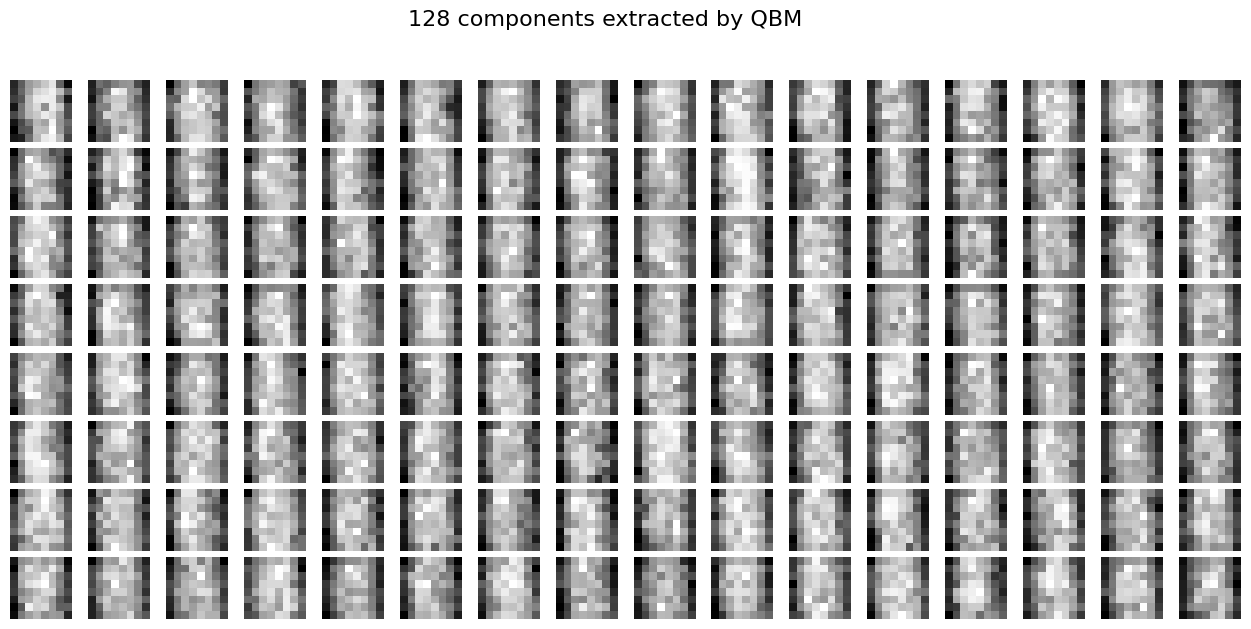

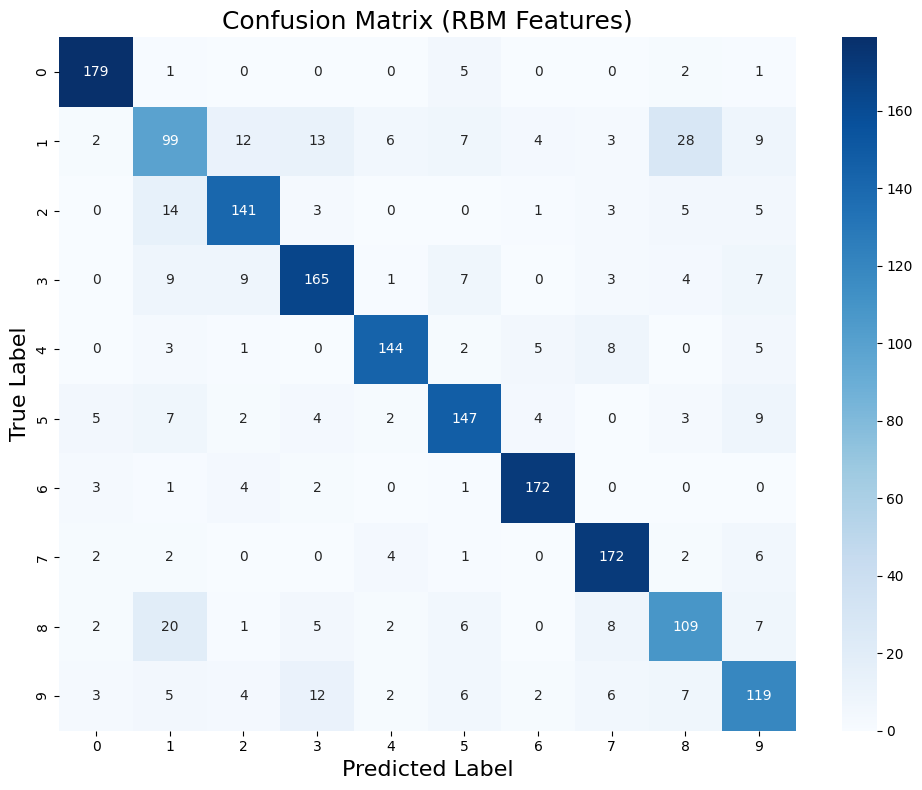

In [3]:
# 绘制权重
rbm.plot_weights(rbm, save_pdf=False)

# 绘制混淆矩阵
rbm.plot_confusion_matrix(y_test, log_pred, title_suffix="RBM Features", save_pdf=False)